In [1]:
# CLASSIFICATION
# 1. Balance the dataset: randomly put aside the extra readings for the gamma “g” class to make both classes equal in size.
# 2. Split data: training set --> 70%, validation set --> 15%, and 15% testing set (Don’t use it while tunning the model parameters).
# 3. Apply K-NN Classifier to the data Manually (Without Scikit- Learn) once (i.e. you create functions for distance calculation, finding K-nearest neighbors & making predictions based on majority vote or whatever implementation you like).
# 4. Re-apply K-NN Classifier to the data by using Scikit-Learn.
# 5. Apply different k values to get the best results in both cases.
# 6. Add your comments on the results and compare between the models. Plot validation accuracy vs. k values for both implementations, identify optimal k-value and discuss overfitting/underfitting trends
# 7. Report all of your final trained model’s accuracy, precision, recall and f-score as well as confusion matrix for both cases and compare between them.

## 1. Importing Libraries

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler


## 2. Loading the Dataset 

In [4]:
# Read the CSV file into a DataFrame
df = pd.read_csv('telescope_data.csv')

# Display the first few rows of the DataFrame
print(df.head())

   Unnamed: 0   fLength    fWidth   fSize   fConc  fConc1     fAsym  fM3Long  \
0           0   28.7967   16.0021  2.6449  0.3918  0.1982   27.7004  22.0110   
1           1   31.6036   11.7235  2.5185  0.5303  0.3773   26.2722  23.8238   
2           2  162.0520  136.0310  4.0612  0.0374  0.0187  116.7410 -64.8580   
3           3   23.8172    9.5728  2.3385  0.6147  0.3922   27.2107  -6.4633   
4           4   75.1362   30.9205  3.1611  0.3168  0.1832   -5.5277  28.5525   

   fM3Trans   fAlpha     fDist class  
0   -8.2027  40.0920   81.8828     g  
1   -9.9574   6.3609  205.2610     g  
2  -45.2160  76.9600  256.7880     g  
3   -7.1513  10.4490  116.7370     g  
4   21.8393   4.6480  356.4620     g  


## 3. Balancing the Dataset

In [5]:
gamma = df[df['class'] == 'g'].sample(n=6688, random_state=42)
hadron = df[df['class'] == 'h']
df_balanced = pd.concat([gamma, hadron])
df_shuffled = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True) 

In [6]:
class_count_before = df['class'].value_counts()
class_count_after  = df_shuffled['class'].value_counts()

print("Counts of each class (Before):")
print(class_count_before)
print("")
print("Counts of each class (After):")
print(class_count_after)

Counts of each class (Before):
g    12332
h     6688
Name: class, dtype: int64

Counts of each class (After):
h    6688
g    6688
Name: class, dtype: int64


## 4. Split the Dataset

In [7]:
# Split
X = df_shuffled.iloc[:, 1:-1]
y = df_shuffled.iloc[:, -1]


y = np.where(y == 'g', 0, 1)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Convert y_train and y_val to numpy arrays
y_train = np.asarray(y_train)
y_val = np.asarray(y_val)
y_test = np.asarray(y_test)

## 5. Feature Scaling


In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


## 6. Applying K-NN Manually

### a. Euclidean Distance

In [9]:
# Euclidean Distance Function (Test points vs Train points)

def euclidean_distance(X_val, X_train):
    # Convert to NumPy arrays
    test_array = np.asarray(X_val)
    train_array = np.asarray(X_train)

    # Compute squared norms
    test_sq = np.sum(test_array**2, axis=1).reshape(-1, 1)     # shape: (n_test, 1)
    train_sq = np.sum(train_array**2, axis=1).reshape(1, -1)   # shape: (1, n_train)

    # Compute full distance matrix using broadcasting
    distances = np.sqrt(test_sq - 2 * np.dot(test_array, train_array.T) + train_sq)  # shape: (n_test, n_train)

    return distances


### b. Making Predictions

In [10]:

def predict(distances, k, y_train, y_val):
    # distances: shape (n_val, n_train)
    # y_train: labels for training set (0 for 'g', 1 for 'h')
    # y_val: labels for validation set

    n_val = distances.shape[0]
    predictions = []

    # Get top-k indices for each validation sample
    nearest_neighbors = np.argsort(distances, axis=1)[:, :k]  # shape: (n_val, k)

    for i in range(n_val):
        neighbor_indices = nearest_neighbors[i]  # shape: (k,)
        neighbor_labels = y_train[neighbor_indices]  # shape: (k,)
        # Majority vote
        prediction = np.bincount(neighbor_labels).argmax()
        predictions.append(prediction)

    # Confusion matrix components
    TP = TN = FP = FN = 0

    for yt, yp in zip(y_val, predictions):
        if yt == 1 and yp == 1:
            TP += 1
        elif yt == 0 and yp == 0:
            TN += 1
        elif yt == 0 and yp == 1:
            FP += 1
        elif yt == 1 and yp == 0:
            FN += 1

    # Metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1, TP, FP, TN, FN


### c. Testing Multiple Values of K 

In [11]:
k_values = [1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70]
accuracies_list = []

for k in k_values:
    
    predictions = []
    dist = euclidean_distance(X_val, X_train)
    accuracy, precision, recall, f1, TP, FP, TN, FN = predict(dist, k, y_train, y_val)

    accuracies_list.append(accuracy)
    
print(accuracies_list)  

C:\Users\HP\AppData\Local\Temp\ipykernel_3676\266815979.py:13: RuntimeWarning: invalid value encountered in sqrt
  distances = np.sqrt(test_sq - 2 * np.dot(test_array, train_array.T) + train_sq)  # shape: (n_test, n_train)


[0.7971086739780658, 0.7836490528414756, 0.8120638085742772, 0.8015952143569293, 0.8165503489531406, 0.8075772681954138, 0.8180458624127617, 0.8130608175473579, 0.8160518444666002, 0.8165503489531406, 0.8120638085742772, 0.8135593220338984, 0.8090727816550349, 0.80259222333001, 0.8020937188434696, 0.8010967098703888]


In [ ]:
# Optimal K chosen for Manual Implementation: K = 7

### d. Plotting Validation Accuracy vs. Value of k

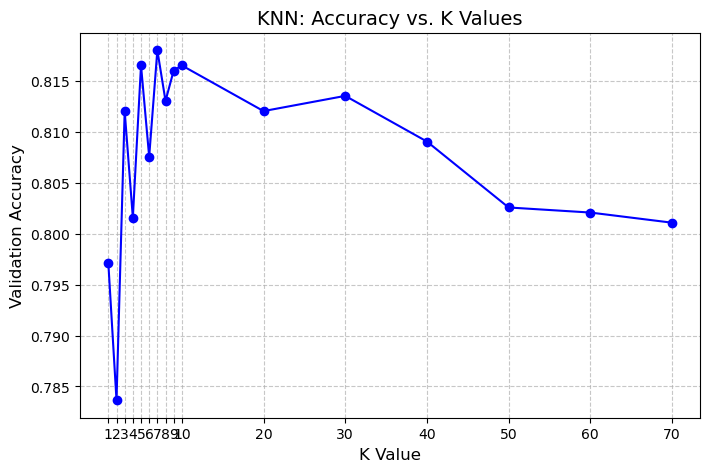

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies_list, marker='o', linestyle='-', color='blue')

# Customize the plot
plt.xlabel('K Value', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('KNN: Accuracy vs. K Values', fontsize=14)
plt.xticks(k_values)
plt.grid(True, linestyle='--', alpha=0.7)


plt.show()

### e. Testing on Optimal Value of K = 7

In [21]:
dist_optimal = euclidean_distance(X_test, X_train)
accuracy, precision, recall, f1, TP, FP, TN, FN = predict(dist_optimal, 7, y_train, y_test)

print("Confusion Matrix:")
print(f"TP: {TP}, FP: {FP}")
print(f"FN: {FN}, TN: {TN}")

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


C:\Users\HP\AppData\Local\Temp\ipykernel_3676\266815979.py:13: RuntimeWarning: invalid value encountered in sqrt
  distances = np.sqrt(test_sq - 2 * np.dot(test_array, train_array.T) + train_sq)  # shape: (n_test, n_train)


Confusion Matrix:
TP: 742, FP: 114
FN: 261, TN: 890
Accuracy: 0.8132
Precision: 0.8668
Recall: 0.7398
F1 Score: 0.7983


## 7. Applying KNN using Scikit-Learn

In [14]:
from sklearn.neighbors import KNeighborsClassifier

accuracies_sk = []

for k in k_values:
    
    knn = KNeighborsClassifier(n_neighbors = k, metric='euclidean', weights='uniform', algorithm='auto')
    # n_neigbors -> k
    # metric = 'euclidean' --> Use this metric for euclidean distance
    # weights = 'uniform' --> All classes are uniform (1) when counting votes 
    # algorithm = 'auto' --> Automatically seleccts best alogrithm from: kd_tree, ball_tree, brute

    # Train the model
    knn.fit(X_train, y_train)  

    # Automatic majority voting + Tie-Breaking: Lower number in predictions array
    y_pred = knn.predict(X_val)

    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)

    accuracies_sk.append(accuracy)

print(accuracies_sk)

[0.7976071784646062, 0.784147557328016, 0.8120638085742772, 0.8020937188434696, 0.8170488534396809, 0.8075772681954138, 0.8180458624127617, 0.8130608175473579, 0.8160518444666002, 0.8165503489531406, 0.8120638085742772, 0.8135593220338984, 0.8090727816550349, 0.80259222333001, 0.8020937188434696, 0.8010967098703888]


In [15]:
# Optimal K for Scikit-Learn: K = 9

## 8. Testing on Optimal Value of K = 7

In [19]:
knn_optimal = KNeighborsClassifier(n_neighbors = 7, metric='euclidean', weights='uniform', algorithm='auto')

knn_optimal.fit(X_test, y_test)

y_pred_optimal = knn_optimal.predict(X_val)

accuracy = accuracy_score(y_val, y_pred_optimal)
precision = precision_score(y_val, y_pred_optimal, average='weighted')  
recall = recall_score(y_val, y_pred_optimal, average='weighted')
f1 = f1_score(y_val, y_pred_optimal, average='weighted')
cm = confusion_matrix(y_val, y_pred_optimal)  

print("Confusion Matrix:")
print(cm)
print("Accuracy:")
print(accuracy)
print("Precision:")
print(precision)
print("Recall: ")
print(recall)
print("F1 Score: ")
print(f1)



Confusion Matrix:
[[872 131]
 [289 714]]
Accuracy:
0.7906281156530409
Precision:
0.7980235361272929
Recall: 
0.7906281156530409
F1 Score: 
0.7893211225004202


## 9. Plotting Validation Accuracy vs. values of K


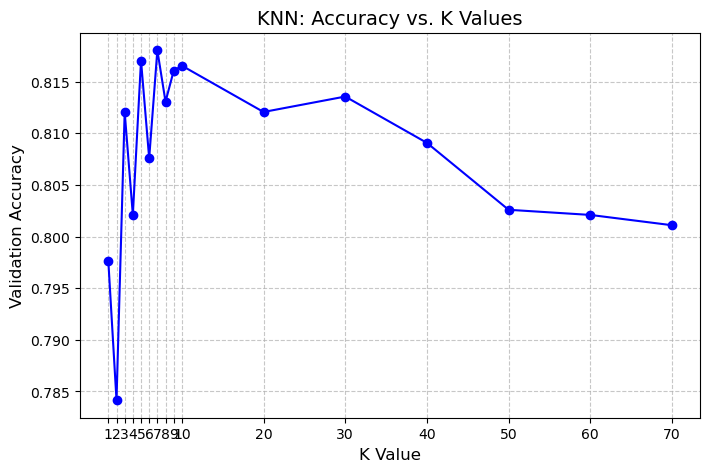

In [20]:
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies_sk, marker='o', linestyle='-', color='blue')

# Customize the plot
plt.xlabel('K Value', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('KNN: Accuracy vs. K Values', fontsize=14)
plt.xticks(k_values)
plt.grid(True, linestyle='--', alpha=0.7)


plt.show()